In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
PATH = "/content/drive/MyDrive/dataset/ch10/kftt-data-1.0/data/tok/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


以下のファイルを利用します。

* kftt-data-1.0/data/tok/kyoto-train.cln.ja
* kftt-data-1.0/data/tok/kyoto-train.cln.en
* kftt-data-1.0/data/tok/kyoto-dev.ja
* kftt-data-1.0/data/tok/kyoto-dev.en
* kftt-data-1.0/data/tok/kyoto-test.ja
* kftt-data-1.0/data/tok/kyoto-test.en

In [ ]:
train_ja = PATH + "kyoto-train.cln.ja"
train_en = PATH + "kyoto-train.cln.en"

In [ ]:
!pip install sentencepiece
!pip3 install sacrebleu
!pip install optuna
!pip install flask-ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Japanese-English Subtitle Corpus (JESC) を利用するため
!wget https://nlp.stanford.edu/projects/jesc/data/split.tar.gz
!tar -zxvf split.tar.gz

--2024-07-28 11:12:21--  https://nlp.stanford.edu/projects/jesc/data/split.tar.gz
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102198329 (97M) [application/x-gzip]
Saving to: ‘split.tar.gz’

split.tar.gz        100%[===================>]  97.46M  3.73MB/s    in 26s     

2024-07-28 11:12:47 (3.79 MB/s) - ‘split.tar.gz’ saved [102198329/102198329]

split/
split/train
split/dev
split/test


In [ ]:
# Japanese-English Subtitle Corpus (JESC) を利用するため
!wget https://nlp.stanford.edu/projects/jesc/data/raw.tar.gz
!tar -zxvf raw.tar.gz

--2024-07-28 11:12:49--  https://nlp.stanford.edu/projects/jesc/data/raw.tar.gz
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102198198 (97M) [application/x-gzip]
Saving to: ‘raw.tar.gz’

raw.tar.gz          100%[===================>]  97.46M  15.0MB/s    in 19s     

2024-07-28 11:13:09 (5.24 MB/s) - ‘raw.tar.gz’ saved [102198198/102198198]

raw/
raw/raw


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
import numpy as np
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, Dataset, DataLoader

import sentencepiece as spm

In [ ]:

spm.SentencePieceTrainer.Train(f"--input={train_ja} --model_prefix=kyoto_ja --vocab_size=16000 --character_coverage=0.9995")

spm.SentencePieceTrainer.Train(f"--input={train_en} --model_prefix=kyoto_en --vocab_size=16000 --character_coverage=1.0")

# 入力テキストを解析し、サブワード単位のトークン化を行うモデルを生成する
# input　入力dataset
# model_prefix 出力model
# vocab_size  サブワードの数
# character_coverage  文字のカバレッジ率

In [ ]:
with open('split/train') as f:
  lines = f.readlines()

print(len(lines))
# JESCを読み込む

In [ ]:
num_line = 700000

with open('/content/drive/MyDrive/dataset/ch10/train-en.txt', 'w') as f1:
  for i in range(num_line):
    line_en = lines[i].split('\t')[0]
    f1.write(line_en + '\n')

with open('/content/drive/MyDrive/dataset/ch10/train-ja.txt', 'w') as f2:
  for i in range(num_line):
    line_ja = lines[i].split('\t')[1].replace('\n', '')
    f2.write(line_ja + '\n')

# num_line行の英語と日本語のテキストをそれぞれ別々のファイルに保存する

In [ ]:
def word2id_tensor(model, data):
  sp = spm.SentencePieceProcessor()
  sp.load(model)

  with open(data) as f:
    lines = f.readlines()

  list_data = []
  for line in lines:
    ids = sp.EncodeAsIds(line)
    ids.insert(0,1) # 開始トークン ID
    ids.append(2) # 終了トークン ID
    list_data.append(ids)

  return list_data

# SentencePiece モデルを使用してテキストデータを ID のリストに変換して

In [ ]:
pad_id = 0
sos_id = 1
eos_id = 2

X_train = word2id_tensor('kyoto_ja.model', 'train-ja.txt')
Y_train = word2id_tensor('kyoto_en.model', 'train-en.txt')

In [ ]:
X_train = word2id_tensor('kyoto_ja.model', PATH + 'kyoto-train.cln.ja')
Y_train = word2id_tensor('kyoto_en.model', PATH + 'kyoto-train.cln.en')

X_valid = word2id_tensor('kyoto_ja.model', PATH + 'kyoto-dev.ja')
Y_valid = word2id_tensor('kyoto_en.model', PATH + 'kyoto-dev.en')

X_test = word2id_tensor('kyoto_ja.model', PATH + 'kyoto-test.ja')
Y_test = word2id_tensor('kyoto_en.model', PATH + 'kyoto-test.en')

# datasetをloadする

In [ ]:
class MyDataset(Dataset):
    def __init__(self, xdata, ydata):
        self.data = xdata
        self.label = ydata
    # データとラベルをそれぞれ保存する


    def __len__(self):
        return len(self.label)
    # 長さをもらう

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        return (x,y)
    # indexによって、データとラベルをもらう

def my_collate_fn(batch):
    images, targets= list(zip(*batch))
    xs = list(images)
    ys = list(targets)
    return xs, ys
# dataloaderがbatchを作るため

In [ ]:
batch_size = 4
dataset = MyDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
# dataloaderを作る

In [ ]:
class MyAttNMT(nn.Module):
    def __init__(self, jv, ev, k):
        super(MyAttNMT, self).__init__()
        self.jemb = nn.Embedding(jv, k, padding_idx=0)
        # 日本語の埋め込み層
        self.eemb = nn.Embedding(ev, k, padding_idx=0)
        # 英語の埋め込み層

        self.lstm1 = nn.LSTM(k, k, num_layers=2, batch_first=True)
        # エンコーダー（日本語用）
        self.lstm2 = nn.LSTM(k, k, num_layers=2, batch_first=True)
        # デコーダー （英語用）

        self.Wc = nn.Linear(2*k, k)
        # コンテキストとデコーダー出力を結合するための線形変換
        self.W = nn.Linear(k, ev)
        # 出力層

    def forward(self, jline, eline):
        x = self.jemb(jline)
        ox, (hnx, cnx) = self.lstm1(x)
        # 日本語のテキストを埋め込み、エンコーダーに入力する

        y = self.eemb(eline)
        oy, (hny, cny) = self.lstm2(y,(hnx, cnx))
        # 英語のテキストを埋め込み、エンコーダーの最終状態を初期状態としてデコーダーに入力する

        ox1 = ox.permute(0,2,1)
        sim = torch.bmm(oy,ox1)
        bs, yws, xws = sim.shape
        sim2 = sim.reshape(bs*yws,xws)
        alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
        # attentionを計算する
        # デコーダー出力とエンコーダー出力のドット積を計算し、ソフトマックスを適用してalphaを計算する

        ct = torch.bmm(alpha,ox)
        oy1 = torch.cat([ct,oy],dim=2)
        oy2 = self.Wc(oy1)
        # コンテキストベクトルの計算

        return self.W(oy2)

In [ ]:
jv = 16000
ev = 16000
demb = 200

net = MyAttNMT(jv, ev, demb).to(device)
# netを構築する

optimizer = optim.SGD(net.parameters(),lr=0.009)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
# オプティマイザと損失関数を定義する

In [ ]:
epoch = 20

net.train()
for ep in range(epoch):
    i = 0
    for xs, ys in dataloader:
        xs1, ys1, ys2 = [], [], []
        for k in range(len(xs)):
            tid = xs[k]
            xs1.append(torch.LongTensor(tid[1:]))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid[:-1]))
            ys2.append(torch.LongTensor(tid[1:]))


        jinput = pad_sequence(xs1, batch_first=True).to(device)
        einput = pad_sequence(ys1, batch_first=True).to(device)
        gans = pad_sequence(ys2, batch_first=True, padding_value=-1.0).to(device)
        # pad_sequenceによって、同じ形のtensorに変更する

        out = net(jinput, einput)
        # 順伝播
        loss = criterion(out[0],gans[0])
        for h in range(1,len(gans)):
            loss += criterion(out[h],gans[h])
        print(ep, i, loss.item())
        # lossを計算する
        optimizer.zero_grad()
        # 勾配を初期化する
        loss.backward()
        # 逆伝播
        optimizer.step()
        i += 1

    outfile = "/content/drive/MyDrive/dataset/ch10/" + "attnmt2-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)
    # modelを保存する

流式输出内容被截断，只能显示最后 5000 行内容。
19 77471 11.97354507446289
19 77472 8.904107093811035
19 77473 10.022167205810547
19 77474 13.065723419189453
19 77475 9.766300201416016
19 77476 11.216891288757324
19 77477 4.535258769989014
19 77478 8.875240325927734
19 77479 7.080216407775879
19 77480 10.277521133422852
19 77481 13.601906776428223
19 77482 9.922001838684082
19 77483 8.917481422424316
19 77484 6.856414794921875
19 77485 9.956475257873535
19 77486 11.088218688964844
19 77487 12.199135780334473
19 77488 8.681840896606445
19 77489 11.569296836853027
19 77490 13.404342651367188
19 77491 9.278464317321777
19 77492 6.075153350830078
19 77493 9.091876029968262
19 77494 7.111638069152832
19 77495 13.911993980407715
19 77496 7.9379472732543945
19 77497 9.058797836303711
19 77498 13.769720077514648
19 77499 9.327913284301758
19 77500 11.07641887664795
19 77501 8.302175521850586
19 77502 12.236087799072266
19 77503 7.444127082824707
19 77504 11.436666488647461
19 77505 10.819948196411133
19 77506 10.0

In [ ]:
jdata = X_test
edata = Y_test

sp = spm.SentencePieceProcessor()
sp.load("kyoto_en.model")
# 学習済みのSentencePieceモデルをロードする

true_list = []
pre_list = []

net.eval()
with torch.no_grad():
    for i in range(len(jdata)):
        jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
        # EOSを除くため
        x = net.jemb(jinput)
        # 日本語の埋め込み層の出力をもらう
        ox, (hnx, cnx) = net.lstm1(x)
        # エンコーダーによって、出力を処理する
        wid = sos_id
        sl = 0
        en_list = []
        while True:
            wids = torch.LongTensor([[ wid ]]).to(device)
            # 今の単語のtensor
            y = net.eemb(wids)
            # 今の単語の埋め込み層の出力
            oy, (hnx, cnx) = net.lstm2(y,(hnx, cnx))
            # デコーダー
            ox1 = ox.permute(0,2,1)
            # 形の調整
            sim = torch.bmm(oy,ox1)
            # ドット積によって類似度を計算する

            bs, yws, xws = sim.shape
            sim2 = sim.reshape(bs*yws,xws)
            alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
            # attentionの重みを計算する

            ct = torch.bmm(alpha,ox)
            # コンテキストベクトルを計算する
            oy1 = torch.cat([ct,oy],dim=2)
            # コンテキストベクトルとデコーダーの出力を組み合わせる
            oy2 = net.Wc(oy1)
            # Linear
            oy3 = net.W(oy2)
            # 出力層
            wid = torch.argmax(oy3[0]).item()
            # 今の予測単語のIDをもらう

            if (wid == eos_id):
                break
            # EOSの時は終了
            en_list.append(wid)
            #print(sp.DecodeIds(wid)," ",end='')
            sl += 1
            if (sl == 200):
                break
        true_l = sp.DecodeIds(edata[i])
        # 実の翻訳のIDによってテキストに変更する
        pre_l = sp.DecodeIds(en_list)
        # 予測の翻訳のIDによってテキストに変更する

        true_list.append(true_l)
        # 実の翻訳
        pre_list.append(pre_l)
        # 予測の翻訳

        # print(f"正解：{true_l}")
        # print(f"予測：{pre_l}")
        #print()

In [ ]:
for i in range(10):
  print(f"正解：{true_list[i]}")
  print(f"予測：{pre_list[i]}")
  print()

正解：Infobox Buddhist
予測：I will take care

正解：Dogen was a Zen monk in the early Kamakura period .
予測：Dogen was the Zen priest during the early Kamakura period .

正解：The founder of Soto Zen
予測：He was the founder of Soto sect .

正解：Later in his life he also went by the name Kigen .
予測：In his later years , he was also used as a name in his later years .

正解：Within the sect he is referred to by the honorary title Koso .
予測：It is honored by the same as the Kyo-hon ( the book of the sect ) .

正解：Posthumously named Bussho Dento Kokushi , or Joyo-Daishi .
予測：His posthumous name was Kyohon kokushi , and he was the Daishi ( 正経 ) .

正解：He is generally called Dogen Zenji .
予測：He is generally called Dogen Zenji .

正解：He is reputed to have been the one that spread the practices of tooth brushing , face washing , table manners and cleaning in Japan .
予測：It is said that the manners of the manners of the Japanese-style balls and goods were said to be the manners of the meal .

正解：Another story has it tha

In [ ]:
import sacrebleu

bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)
print(bleu.score)
# BLEUスコアを計算する

11.658836195001243


In [ ]:
# エポックによって各訓練したmodelのBLEUスコアを計算する

jdata = X_test
edata = Y_test

sp = spm.SentencePieceProcessor()
sp.load("kyoto_en.model")

s = 19

for i in range(20):
  name = f"/content/drive/MyDrive/dataset/ch10/attnmt2-{s}.model"
  net.load_state_dict(torch.load(name))
  true_list = []
  pre_list = []

  net.eval()
  with torch.no_grad():
      for i in range(len(jdata)):
          jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
          x = net.jemb(jinput)
          ox, (hnx, cnx) = net.lstm1(x)
          wid = sos_id
          sl = 0
          en_list = []
          while True:
              wids = torch.LongTensor([[ wid ]]).to(device)
              y = net.eemb(wids)
              oy, (hnx, cnx) = net.lstm2(y,(hnx, cnx))
              ox1 = ox.permute(0,2,1)
              sim = torch.bmm(oy,ox1)
              bs, yws, xws = sim.shape
              sim2 = sim.reshape(bs*yws,xws)
              alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
              ct = torch.bmm(alpha,ox)
              oy1 = torch.cat([ct,oy],dim=2)
              oy2 = net.Wc(oy1)
              oy3 = net.W(oy2)
              wid = torch.argmax(oy3[0]).item()
              if (wid == eos_id):
                  break
              en_list.append(wid)
              #print(sp.DecodeIds(wid)," ",end='')
              sl += 1
              if (sl == 200):
                  break
          true_l = sp.DecodeIds(edata[i])
          pre_l = sp.DecodeIds(en_list)
          true_list.append(true_l)
          pre_list.append(pre_l)

  bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)
  print(f"epoch: {s} , {bleu.score}")
  s = s - 1

epoch: 19 , 11.658836195001243
epoch: 18 , 10.907323283023896
epoch: 17 , 10.840720482764803
epoch: 16 , 11.096911455368335
epoch: 15 , 10.803064636304413
epoch: 14 , 10.78882204501064
epoch: 13 , 11.246600903834059
epoch: 12 , 10.534658869530695
epoch: 11 , 10.680890390047187
epoch: 10 , 10.967132867370283
epoch: 9 , 10.248150879591988
epoch: 8 , 9.833953082767874
epoch: 7 , 9.997474423825349
epoch: 6 , 9.647007160640902
epoch: 5 , 9.021003334861518
epoch: 4 , 7.6401177878698485
epoch: 3 , 8.580891764910248
epoch: 2 , 6.750225570145542
epoch: 1 , 5.151493915067161
epoch: 0 , 3.1867825322970824


In [ ]:
net.load_state_dict(torch.load("/content/drive/MyDrive/dataset/ch10/attnmt2-19.model"))

<All keys matched successfully>

ビーム幅:1 BLEU:11.661590853321812
ビーム幅:2 BLEU:12.570865445696699
ビーム幅:3 BLEU:12.919781692822008
ビーム幅:4 BLEU:12.821575392123604
ビーム幅:5 BLEU:12.799562393285212
ビーム幅:6 BLEU:12.74652410908159
ビーム幅:7 BLEU:12.848740068580144
ビーム幅:8 BLEU:12.620184684749887
ビーム幅:9 BLEU:12.536299548062962
ビーム幅:10 BLEU:12.524389417755797
ビーム幅:11 BLEU:12.436575750260847
ビーム幅:12 BLEU:12.373325505123201
ビーム幅:13 BLEU:12.35620231627745
ビーム幅:14 BLEU:12.250063967655477
ビーム幅:15 BLEU:12.168212020117782
ビーム幅:16 BLEU:12.099946539336235
ビーム幅:17 BLEU:11.893418323740487
ビーム幅:18 BLEU:11.824571522642298
ビーム幅:19 BLEU:11.74133916947364


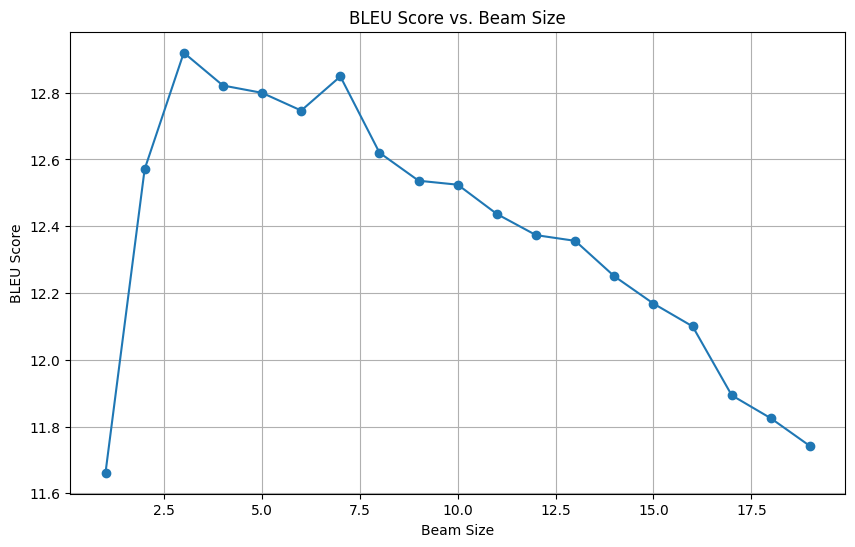

In [ ]:
# 94

import heapq
import sacrebleu
import matplotlib.pyplot as plt

pad_id = 0
sos_id = 1
eos_id = 2

beam_wid_list = []
bleu_score_list = []


jdata = X_test
edata = Y_test

sp = spm.SentencePieceProcessor()
sp.load("kyoto_en.model")

for beam_wid in range(1, 20):

  class Beam:
    def __init__(self):
      self.heap = list()
      self.beam_width = beam_wid
      # beamのwidthを制定する

    def add(self, probility, complete, seq, decoder_input, hnx, cnx):
      heapq.heappush(self.heap, [probility, complete, seq, decoder_input, hnx, cnx])
      # 配列と関連情報をheapに追加する
      # probability: 候補配列の確率
      # complete: 終わったかとか
      # seq: 候補配列
      # decoder_input: デコーダーの入力
      # hnx と cnx: LSTMの状態とセル状態

      if len(self.heap) > self.beam_width:
        heapq.heappop(self.heap)
      # もしheapのサイズがbeam_widthに以上、除く

    def __iter__(self):
      return iter(self.heap)

  true_list = []
  pre_list = []

  net.eval()
  with torch.no_grad():
      for i in range(len(jdata)):
        # テストデータの反復処理
          jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
          # tensorに変更
          x = net.jemb(jinput)
          # 埋め込み層
          ox, (hnx, cnx) = net.lstm1(x)
          # LSTMによってデコーダー
          wid = sos_id
          sl = 0
          en_list = []
          probility = 1
          decoder_input = torch.LongTensor([[ wid ]]).to(device)
          pre_beam = Beam()
          pre_beam.add(1, False, [decoder_input], decoder_input, hnx, cnx)

          # Beam Search
          while True:
            cur_beam = Beam()
            for _probility, _complete, _seq, _decoder_input, _hnx, _cnx in pre_beam:
              # 前回の反復のbeamのすべての候補配列
              if _complete == True:
                cur_beam.add(_probility, _complete, _seq, _decoder_input, _hnx, _cnx)
                # もし配列の検索が完了
                # 今のbeamに入れる
              else:
                y = net.eemb(_decoder_input)
                # 埋め込み層によってdecoderのtokenをベクトルに変更
                oy, (hnx, cnx) = net.lstm2(y, (_hnx, _cnx))
                # 出力ベクトルと状態
                ox1 = ox.permute(0,2,1)
                sim = torch.bmm(oy,ox1)
                # 出力ベクトルとencoderの出力の類似度
                bs, yws, xws = sim.shape
                sim2 = sim.reshape(bs*yws,xws)
                alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
                # attention を計算する
                ct = torch.bmm(alpha,ox)
                # 文脈のベクトルを計算する
                oy1 = torch.cat([ct,oy],dim=2)
                # 文脈のベクトルと出力ベクトルを組み合わせる
                oy2 = net.Wc(oy1)
                # 全結合層
                oy3 = net.W(oy2)
                # 出力層
                oy4 = F.softmax(oy3, dim=2)
                # softmaxによって確立分布をもらう
                value, index = torch.topk(oy4[0], beam_wid)
                # beam_widの確率とindexを小さい顺にもらう

                for m, n in zip(value[0], index[0]):
                  # 各top_kの候補に対して
                  decoder_input = torch.LongTensor([[ n ]]).to(device)
                  # decoder
                  seq = _seq + [n]
                  probility = _probility * m #* 0.1
                  # 確率を更新
                  if n.item() == eos_id:
                    complete = True
                  else:
                    complete = False
                    # 完了判断
                  cur_beam.add(probility, complete, seq, decoder_input, hnx, cnx)
                  # 今のbeam配列に入れる
            best_prob, best_comp, best_seq, _, _, _ = max(cur_beam)
            # 今のbeam配列に最大の確率をもらう

            if best_comp == True or len(best_seq) == 200:
              ss = best_seq[1:-1]
              for s in range(len(ss)):
                en_list.append(ss[s].item())
              break
            else:
              pre_beam = cur_beam
            # 最適なlistまだlistの長さが最大長さを超えたら
            # 次回のbeam searchをする


          pre_l = sp.DecodeIds(en_list)
          pre_list.append(pre_l)
          # 予測の
          true_l = sp.DecodeIds(edata[i])
          true_list.append(true_l)
          # 本物の
          # IDを文字列に変更する

  bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)
  beam_wid_list.append(beam_wid)
  bleu_score_list.append(bleu.score)
  print(f"ビーム幅:{beam_wid} BLEU:{bleu.score}")
  # bleuを計算する

# グラフを描く
plt.figure(figsize=(10, 6))
plt.plot(beam_wid_list, bleu_score_list, marker='o')
plt.title('BLEU Score vs. Beam Size')
plt.xlabel('Beam Size')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()

In [ ]:
# 95

import sentencepiece as spm
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader

spm.SentencePieceTrainer.Train(f"--input={train_ja} --model_prefix=kyoto_ja --vocab_size=16000 --character_coverage=0.9995")

spm.SentencePieceTrainer.Train(f"--input={train_en} --model_prefix=kyoto_en --vocab_size=16000 --character_coverage=1.0")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyAttNMT(nn.Module):
    def __init__(self, jv, ev, k):
        super(MyAttNMT, self).__init__()
        self.jemb = nn.Embedding(jv, k, padding_idx=0)
        self.eemb = nn.Embedding(ev, k, padding_idx=0)
        self.lstm1 = nn.LSTM(k, k, num_layers=2, batch_first=True)
        self.lstm2 = nn.LSTM(k, k, num_layers=2, batch_first=True)
        self.Wc = nn.Linear(2*k, k)
        self.W = nn.Linear(k, ev)
    def forward(self, jline, eline):
        x = self.jemb(jline)
        ox, (hnx, cnx) = self.lstm1(x)
        # ox = (bitch_size, jline_words, emb_size)

        y = self.eemb(eline)
        oy, (hny, cny) = self.lstm2(y,(hnx, cnx))
        # oy = (bitch_size, eline_words, emb_size)

        ox1 = ox.permute(0,2,1)
        # ox1 = (bitch_size, emb_size, jline_words)

        sim = torch.bmm(oy,ox1)
        # sim = (bitch_size, eline_words, jline_words)

        bs, yws, xws = sim.shape
        # bs=bitch_size  yws=eline_words  xws=jline_words

        sim2 = sim.reshape(bs*yws,xws)
        # sim2 = (bitch_size * eline_words, jline_words)

        alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
        # alpha = (bitch_size, eline_words, jline_words)

        ct = torch.bmm(alpha,ox)
        # ct = (bitch_size, eline_words, emb_size)

        oy1 = torch.cat([ct,oy],dim=2)
        # oy1 = (bitch_size, eline_words, emb_size*2)

        oy2 = self.Wc(oy1)
        return self.W(oy2)

# 94と違う
def word2id_tensor(model, data):
    sp = spm.SentencePieceProcessor()
    sp.load(model)
    # modelをloadする

    with open(data) as f:
        lines = f.readlines()
    # dataを読み込む

    list_data = []
    for line in lines:
        ids = sp.EncodeAsIds(line)
        ids.insert(0, 1)
        ids.append(2)
        list_data.append(torch.tensor(ids[:42]))

    # テキストをsubwordによって分けて、idをもらう

    packed_inputs = pack_sequence(list_data, enforce_sorted=False)
    # pad_sequence によるパディング
    padded_packed_inputs, _ = pad_packed_sequence(packed_inputs, batch_first=True, total_length=42)
    # pack_padded_sequence によるパッキング
    return padded_packed_inputs


X_train = word2id_tensor('kyoto_ja.model', PATH + 'kyoto-train.cln.ja')
Y_train = word2id_tensor('kyoto_en.model', PATH + 'kyoto-train.cln.en')

X_valid = word2id_tensor('kyoto_ja.model', PATH + 'kyoto-dev.ja')
Y_valid = word2id_tensor('kyoto_en.model', PATH + 'kyoto-dev.en')

X_test = word2id_tensor('kyoto_ja.model', PATH + 'kyoto-test.ja')
Y_test = word2id_tensor('kyoto_en.model', PATH + 'kyoto-test.en')

batch_size = 128

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid, Y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

jv = 16000
ev = 16000
demb = 200

net = MyAttNMT(jv, ev, demb).to(device)
optimizer = optim.SGD(net.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

net.train()
for ep in range(20):
    i = 0
    for xs, ys in train_loader:
        xs1, ys1, ys2 = [], [], []
        for k in range(len(xs)):
            tid = xs[k]
            xs1.append(torch.LongTensor(tid[1:]))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid[:-1]))
            ys2.append(torch.LongTensor(tid[1:]))
        jinput = pad_sequence(xs1, batch_first=True).to(device)
        einput = pad_sequence(ys1, batch_first=True).to(device)
        gans = pad_sequence(ys2, batch_first=True, padding_value=-1.0).to(device)
        out = net(jinput, einput)
        loss = criterion(out[0],gans[0])
        for h in range(1,len(gans)):
            loss += criterion(out[h],gans[h])
        print(ep, i, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
    outfile = "/content/drive/MyDrive/dataset/ch10/" + "attnmt3-" + str(ep) + ".model"
    torch.save(net.state_dict(),outfile)

In [ ]:
import sacrebleu

jdata = X_test
edata = Y_test

sp = spm.SentencePieceProcessor()
sp.load("kyoto_en.model")

s = 19

for i in range(20):
  name = f"/content/drive/MyDrive/dataset/ch10/attnmt3-{s}.model"
  net.load_state_dict(torch.load(name))
  true_list = []
  pre_list = []

  net.eval()
  with torch.no_grad():
      for i in range(len(jdata)):
          jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
          x = net.jemb(jinput)
          ox, (hnx, cnx) = net.lstm1(x)
          wid = sos_id
          sl = 0
          en_list = []
          while True:
              wids = torch.LongTensor([[ wid ]]).to(device)
              y = net.eemb(wids)
              oy, (hnx, cnx) = net.lstm2(y,(hnx, cnx))
              ox1 = ox.permute(0,2,1)
              sim = torch.bmm(oy,ox1)
              bs, yws, xws = sim.shape
              sim2 = sim.reshape(bs*yws,xws)
              alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
              ct = torch.bmm(alpha,ox)
              oy1 = torch.cat([ct,oy],dim=2)
              oy2 = net.Wc(oy1)
              oy3 = net.W(oy2)
              wid = torch.argmax(oy3[0]).item()
              if (wid == eos_id):
                  break
              en_list.append(wid)
              #print(sp.DecodeIds(wid)," ",end='')
              sl += 1
              if (sl == 200):
                  break
          true_l = sp.DecodeIds(edata[i])
          pre_l = sp.DecodeIds(en_list)
          true_list.append(true_l)
          pre_list.append(pre_l)

  bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)
  print(f"epoch: {s} , {bleu.score}")
  s = s - 1

epoch: 19 , 11.658836195001243
epoch: 18 , 10.907323283023896
epoch: 17 , 10.840720482764803
epoch: 16 , 11.096911455368335
epoch: 15 , 10.803064636304413
epoch: 14 , 10.78882204501064
epoch: 13 , 11.246600903834059
epoch: 12 , 10.534658869530695
epoch: 11 , 10.680890390047187
epoch: 10 , 10.967132867370283
epoch: 9 , 10.248150879591988
epoch: 8 , 9.833953082767874
epoch: 7 , 9.997474423825349
epoch: 6 , 9.647007160640902
epoch: 5 , 9.021003334861518
epoch: 4 , 7.6401177878698485
epoch: 3 , 8.580891764910248
epoch: 2 , 6.750225570145542
epoch: 1 , 5.151493915067161
epoch: 0 , 3.1867825322970824


In [ ]:
net.load_state_dict(torch.load("/content/drive/MyDrive/dataset/ch10/attnmt3-19.model"))

<All keys matched successfully>

ビーム幅:1 BLEU:10.91057944574951
ビーム幅:2 BLEU:12.301963439950582
ビーム幅:3 BLEU:12.77165581187699
ビーム幅:4 BLEU:12.648567669780423
ビーム幅:5 BLEU:12.601567582529341
ビーム幅:6 BLEU:12.642562828413872
ビーム幅:7 BLEU:12.510000416167738
ビーム幅:8 BLEU:12.453044971018539
ビーム幅:9 BLEU:12.493345522931833
ビーム幅:10 BLEU:12.511936087994123
ビーム幅:11 BLEU:12.53155975450838
ビーム幅:12 BLEU:12.502419227296798
ビーム幅:13 BLEU:12.457472330030095
ビーム幅:14 BLEU:12.350028196929523
ビーム幅:15 BLEU:12.360632431701713
ビーム幅:16 BLEU:12.355194481791036
ビーム幅:17 BLEU:12.276121555988663
ビーム幅:18 BLEU:12.187463605643808
ビーム幅:19 BLEU:12.176544635284221


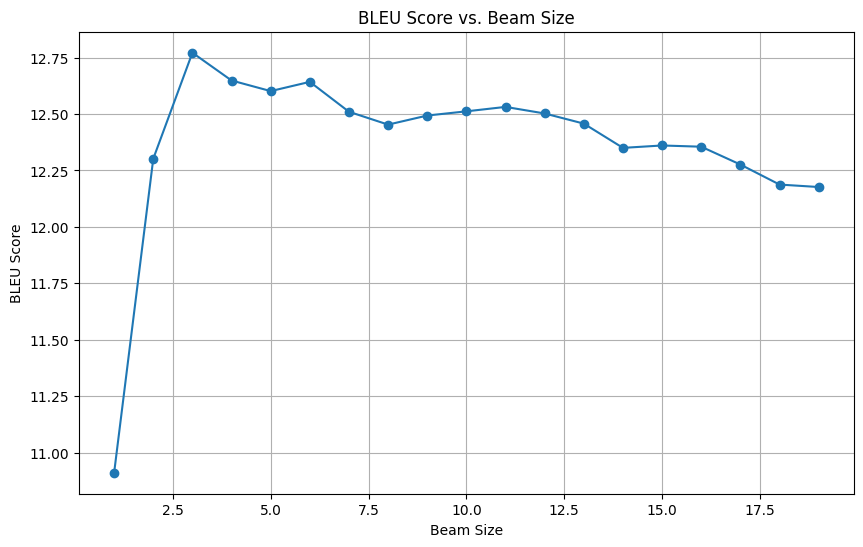

In [ ]:
import heapq
import sacrebleu
import matplotlib.pyplot as plt

pad_id = 0
sos_id = 1
eos_id = 2

beam_wid_list = []
bleu_score_list = []


jdata = X_test
edata = Y_test

sp = spm.SentencePieceProcessor()
sp.load("kyoto_en.model")

for beam_wid in range(1, 20):

  class Beam:
    def __init__(self):
      self.heap = list()
      self.beam_width = beam_wid

    def add(self, probility, complete, seq, decoder_input, hnx, cnx):
      heapq.heappush(self.heap, [probility, complete, seq, decoder_input, hnx, cnx])
      if len(self.heap) > self.beam_width:
        heapq.heappop(self.heap)

    def __iter__(self):
      return iter(self.heap)

  true_list = []
  pre_list = []

  net.eval()
  with torch.no_grad():
      for i in range(len(jdata)):
          jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
          x = net.jemb(jinput)
          ox, (hnx, cnx) = net.lstm1(x)
          wid = sos_id
          sl = 0
          en_list = []
          probility = 1
          decoder_input = torch.LongTensor([[ wid ]]).to(device)
          pre_beam = Beam()
          pre_beam.add(1, False, [decoder_input], decoder_input, hnx, cnx)
          while True:
            cur_beam = Beam()
            for _probility, _complete, _seq, _decoder_input, _hnx, _cnx in pre_beam:
              if _complete == True:
                cur_beam.add(_probility, _complete, _seq, _decoder_input, _hnx, _cnx)
              else:
                y = net.eemb(_decoder_input)
                oy, (hnx, cnx) = net.lstm2(y, (_hnx, _cnx))
                ox1 = ox.permute(0,2,1)
                sim = torch.bmm(oy,ox1)
                bs, yws, xws = sim.shape
                sim2 = sim.reshape(bs*yws,xws)
                alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
                ct = torch.bmm(alpha,ox)
                oy1 = torch.cat([ct,oy],dim=2)
                oy2 = net.Wc(oy1)
                oy3 = net.W(oy2)
                oy4 = F.softmax(oy3, dim=2)
                value, index = torch.topk(oy4[0], beam_wid)
                for m, n in zip(value[0], index[0]):
                  decoder_input = torch.LongTensor([[ n ]]).to(device)
                  seq = _seq + [n]
                  probility = _probility * m #* 0.1
                  if n.item() == eos_id:
                    complete = True
                  else:
                    complete = False
                  cur_beam.add(probility, complete, seq, decoder_input, hnx, cnx)
            best_prob, best_comp, best_seq, _, _, _ = max(cur_beam)

            if best_comp == True or len(best_seq) == 200:
              ss = best_seq[1:-1]
              for s in range(len(ss)):
                en_list.append(ss[s].item())
              break
            else:
              pre_beam = cur_beam

          pre_l = sp.DecodeIds(en_list)
          pre_list.append(pre_l)
          true_l = sp.DecodeIds(edata[i])
          true_list.append(true_l)

  bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)
  beam_wid_list.append(beam_wid)
  bleu_score_list.append(bleu.score)
  print(f"ビーム幅:{beam_wid} BLEU:{bleu.score}")

plt.figure(figsize=(10, 6))
plt.plot(beam_wid_list, bleu_score_list, marker='o')
plt.title('BLEU Score vs. Beam Size')
plt.xlabel('Beam Size')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()

In [ ]:
# 96

import heapq
import sacrebleu
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.tensorboard import SummaryWriter
import sacrebleu

net.load_state_dict(torch.load("/content/drive/MyDrive/dataset/ch10/attnmt2-19.model"))
# 辞書をload

jdata = X_test
edata = Y_test

sp = spm.SentencePieceProcessor()
sp.load("kyoto_en.model")
# 学習済みのSentencePiece modelをload

writter = SummaryWriter(log_dir='/content/drive/MyDrive/dataset/ch10/test_BLEU_log')
# TensorBoardを利用して

s = 0

for i in range(20):
  name = f"/content/drive/MyDrive/dataset/ch10/attnmt2-{s}.model"
  net.load_state_dict(torch.load(name))
  true_list = []
  pre_list = []

  net.eval()
  with torch.no_grad():
      for i in range(len(jdata)):
          jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
          x = net.jemb(jinput)
          ox, (hnx, cnx) = net.lstm1(x)
          wid = sos_id
          sl = 0
          en_list = []
          while True:
              wids = torch.LongTensor([[ wid ]]).to(device)
              y = net.eemb(wids)
              oy, (hnx, cnx) = net.lstm2(y,(hnx, cnx))
              ox1 = ox.permute(0,2,1)
              sim = torch.bmm(oy,ox1)
              bs, yws, xws = sim.shape
              sim2 = sim.reshape(bs*yws,xws)
              alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
              ct = torch.bmm(alpha,ox)
              oy1 = torch.cat([ct,oy],dim=2)
              oy2 = net.Wc(oy1)
              oy3 = net.W(oy2)
              wid = torch.argmax(oy3[0]).item()
              if (wid == eos_id):
                  break
              en_list.append(wid)
              #print(sp.DecodeIds(wid)," ",end='')
              sl += 1
              if (sl == 200):
                  break
          true_l = sp.DecodeIds(edata[i])
          pre_l = sp.DecodeIds(en_list)
          true_list.append(true_l)
          pre_list.append(pre_l)


  bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)

  writter.add_scalar('BLEU', bleu.score, s)
  # グラフを描く

  print(f"epoch: {s} , {bleu.score}")
  s += 1


writter.close()

epoch: 0 , 3.1867825322970824
epoch: 1 , 5.151493915067161
epoch: 2 , 6.750225570145542
epoch: 3 , 8.580891764910248
epoch: 4 , 7.6401177878698485
epoch: 5 , 9.021003334861518
epoch: 6 , 9.647007160640902
epoch: 7 , 9.997474423825349
epoch: 8 , 9.833953082767874
epoch: 9 , 10.248150879591988
epoch: 10 , 10.967132867370283
epoch: 11 , 10.680890390047187
epoch: 12 , 10.534658869530695
epoch: 13 , 11.246600903834059
epoch: 14 , 10.78882204501064
epoch: 15 , 10.803064636304413
epoch: 16 , 11.096911455368335
epoch: 17 , 10.840720482764803
epoch: 18 , 10.907323283023896
epoch: 19 , 11.658836195001243


In [ ]:
!tensorboard --logdir=/content/drive/MyDrive/dataset/ch10/test_BLEU_log

/bin/bash: line 1: load_ext: command not found
2024-07-21 17:54:55.037100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 17:54:55.037157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 17:54:55.038599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 17:54:56.005300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



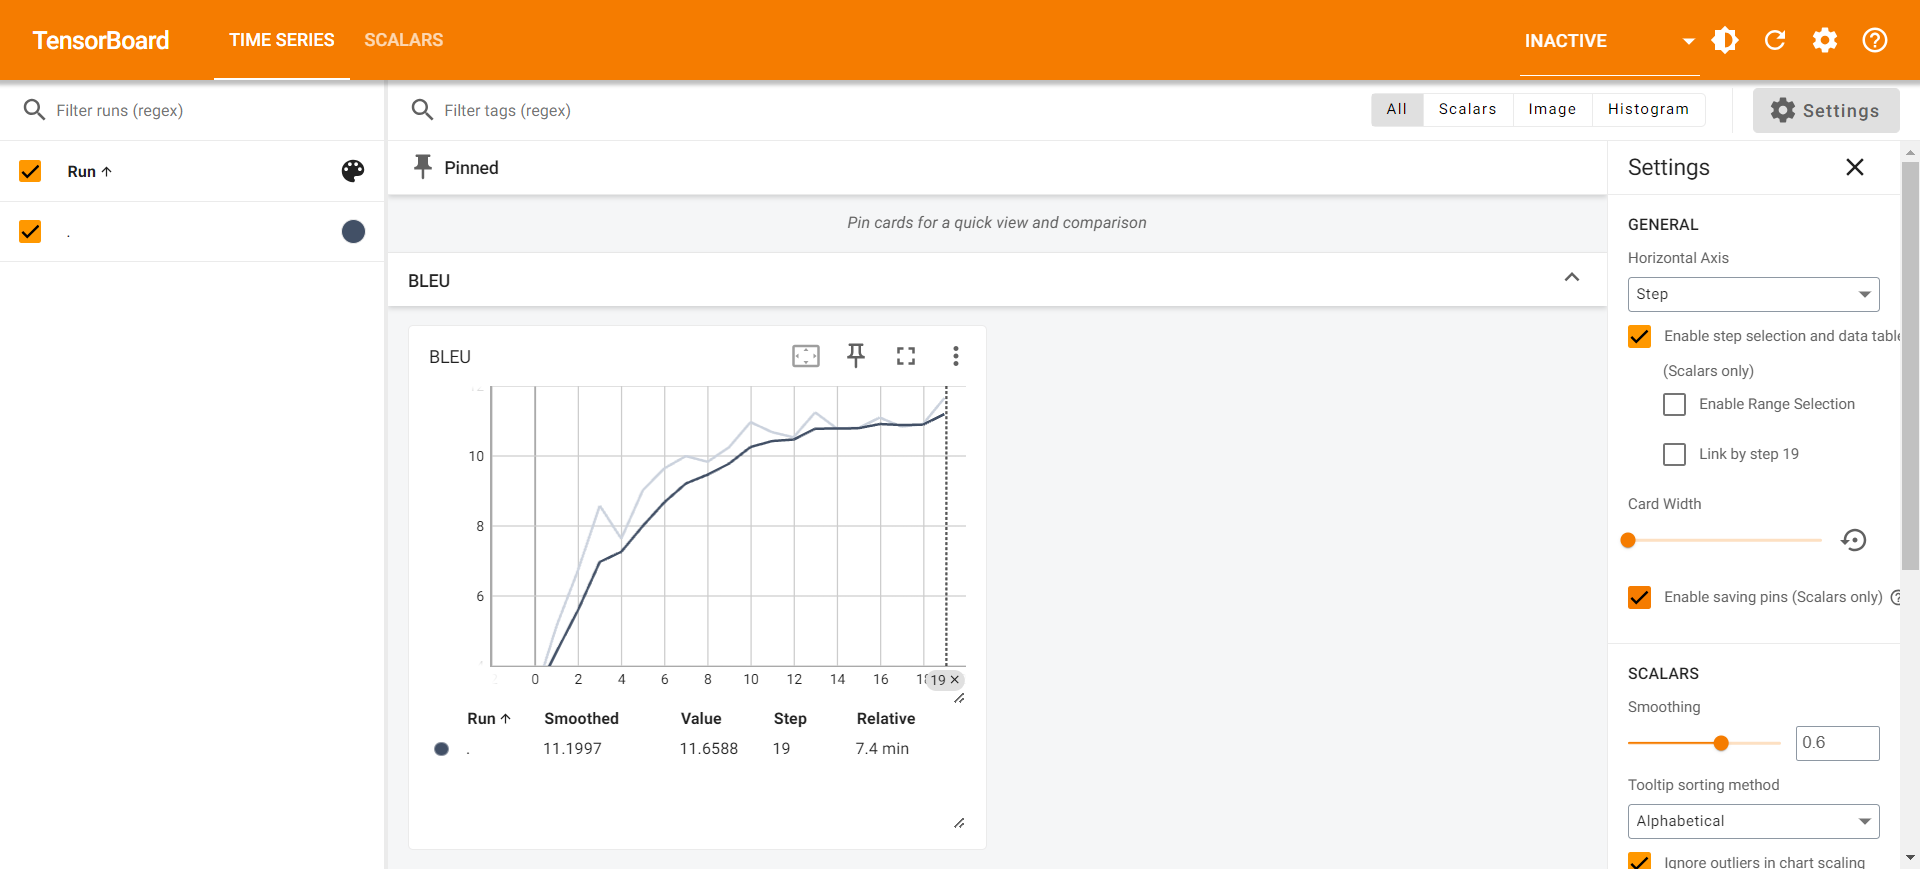

In [ ]:
batch_size = 4
dataset = MyDataset(X_test, Y_test)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

In [ ]:
epoch = 20

writter = SummaryWriter(log_dir='/content/drive/MyDrive/dataset/ch10/test_loss_log')

net.train()
for ep in range(epoch):
    i = 0
    for xs, ys in dataloader:
        xs1, ys1, ys2 = [], [], []
        for k in range(len(xs)):
            tid = xs[k]
            xs1.append(torch.LongTensor(tid[1:]))
            tid = ys[k]
            ys1.append(torch.LongTensor(tid[:-1]))
            ys2.append(torch.LongTensor(tid[1:]))
        jinput = pad_sequence(xs1, batch_first=True).to(device)
        einput = pad_sequence(ys1, batch_first=True).to(device)
        gans = pad_sequence(ys2, batch_first=True, padding_value=-1.0).to(device)
        out = net(jinput, einput)
        loss = criterion(out[0],gans[0])
        for h in range(1,len(gans)):
            loss += criterion(out[h],gans[h])
        print(ep, i, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
    # outfile = "/content/drive/MyDrive/dataset/ch10/" + "attnmt2-" + str(ep) + ".model"
    # torch.save(net.state_dict(),outfile)
    writter.add_scalar('loss',  loss.item(), ep)


writter.close()

流式输出内容被截断，只能显示最后 5000 行内容。
1 59746 9.469653129577637
1 59747 10.839765548706055
1 59748 6.410381317138672
1 59749 9.033373832702637
1 59750 10.091859817504883
1 59751 8.725634574890137
1 59752 4.933600425720215
1 59753 7.11463737487793
1 59754 14.022279739379883
1 59755 6.144280433654785
1 59756 3.483621597290039
1 59757 9.422259330749512
1 59758 9.974658966064453
1 59759 8.602350234985352
1 59760 7.468122482299805
1 59761 8.773969650268555
1 59762 6.5994672775268555
1 59763 6.804769039154053
1 59764 14.499917984008789
1 59765 13.007723808288574
1 59766 4.972740650177002
1 59767 7.438149929046631
1 59768 5.607137680053711
1 59769 11.582242012023926
1 59770 10.824779510498047
1 59771 7.492066383361816
1 59772 7.528017044067383
1 59773 9.299074172973633
1 59774 11.470211029052734
1 59775 5.176743507385254
1 59776 10.199761390686035
1 59777 6.553393363952637
1 59778 7.044580936431885
1 59779 8.403984069824219
1 59780 10.738987922668457
1 59781 8.981149673461914
1 59782 5.503576755523682
1

KeyboardInterrupt: 

In [ ]:
!tensorboard --logdir=/content/drive/MyDrive/dataset/ch10/test_BLEU_log

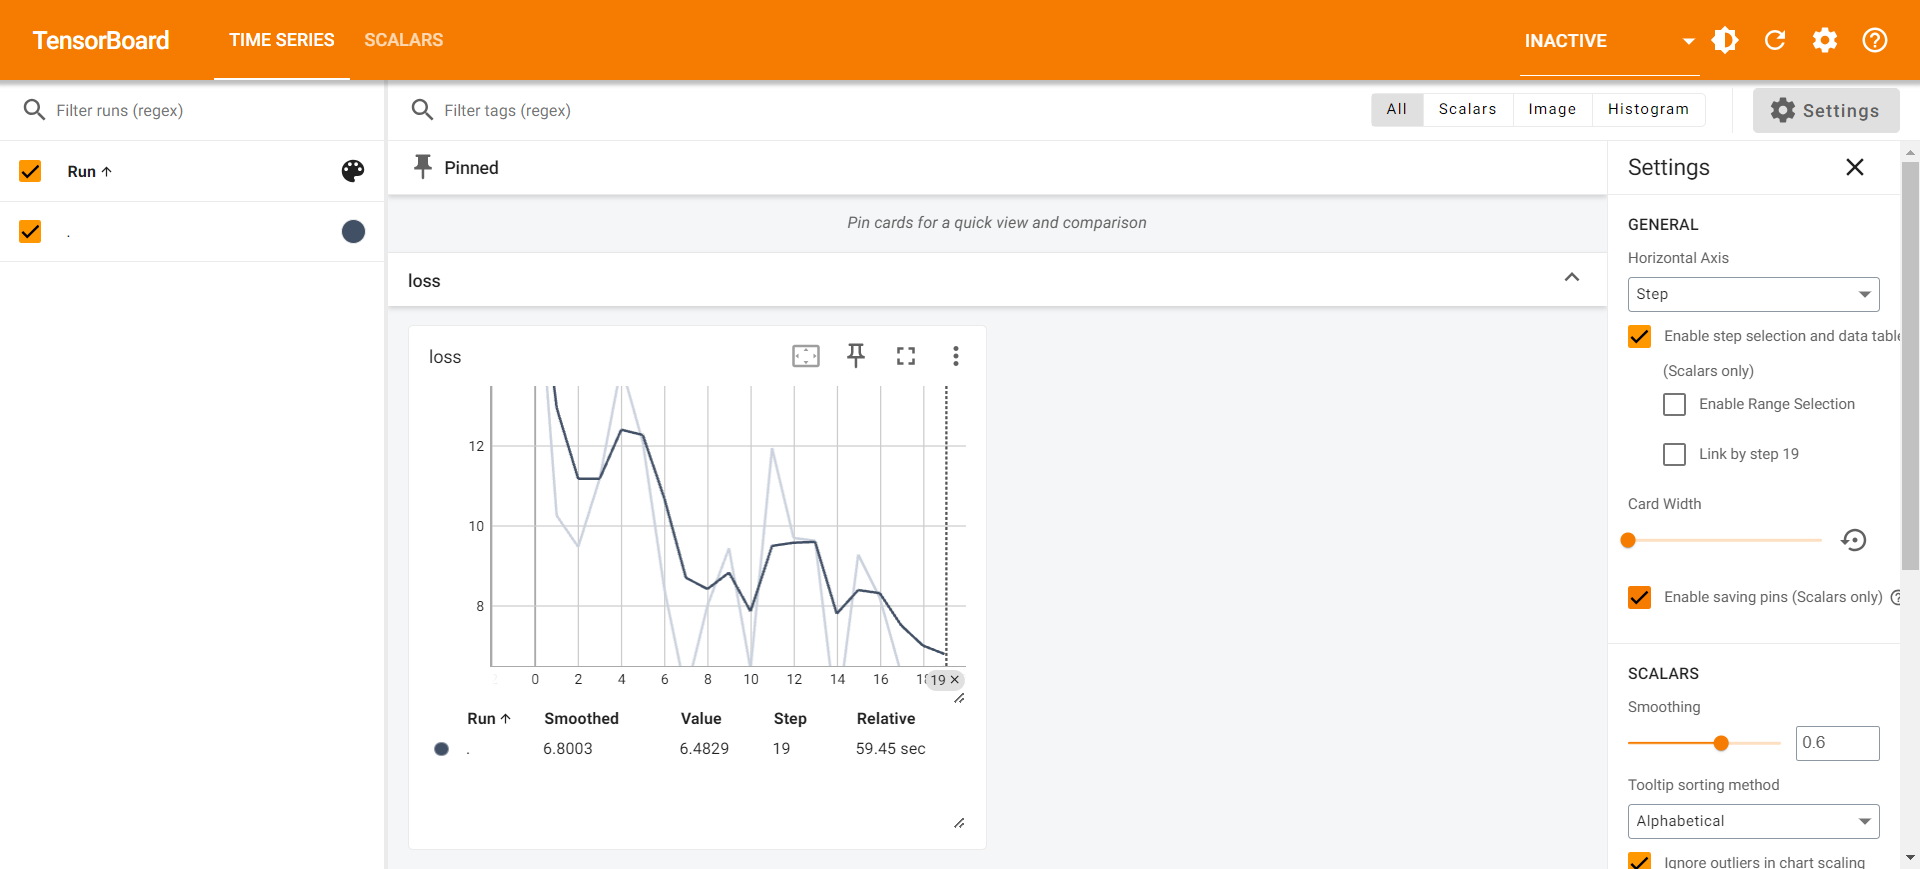

In [ ]:
!pip install optuna

In [ ]:
# 97
import optuna
import sacrebleu


# optunaによって、ハイパー・パラメータを調整する
def objective(trial):

  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)
  # learning_rateの調整

  batch_size = 4
  dataset = MyDataset(X_train, Y_train)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

  net = MyAttNMT(jv, ev, demb).to(device)
  optimizer = optim.SGD(net.parameters(),lr=learning_rate)
  criterion = nn.CrossEntropyLoss(ignore_index=-1)

  epoch = 4

  net.train()
  for ep in range(epoch):
      i = 0
      for xs, ys in dataloader:
          xs1, ys1, ys2 = [], [], []
          for k in range(len(xs)):
              tid = xs[k]
              xs1.append(torch.LongTensor(tid[1:]))
              tid = ys[k]
              ys1.append(torch.LongTensor(tid[:-1]))
              ys2.append(torch.LongTensor(tid[1:]))
          jinput = pad_sequence(xs1, batch_first=True).to(device)
          einput = pad_sequence(ys1, batch_first=True).to(device)
          gans = pad_sequence(ys2, batch_first=True, padding_value=-1.0).to(device)
          out = net(jinput, einput)
          loss = criterion(out[0],gans[0])
          for h in range(1,len(gans)):
              loss += criterion(out[h],gans[h])
          #print(ep, i, loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

  jdata = X_test
  edata = Y_test

  sp = spm.SentencePieceProcessor()
  sp.load("kyoto_en.model")

  true_list = []
  pre_list = []

  net.eval()
  with torch.no_grad():
      for i in range(len(jdata)):
          jinput = torch.LongTensor([ jdata[i][1:] ]).to(device)
          x = net.jemb(jinput)
          ox, (hnx, cnx) = net.lstm1(x)
          wid = sos_id
          sl = 0
          en_list = []
          while True:
              wids = torch.LongTensor([[ wid ]]).to(device)
              y = net.eemb(wids)
              oy, (hnx, cnx) = net.lstm2(y,(hnx, cnx))
              ox1 = ox.permute(0,2,1)
              sim = torch.bmm(oy,ox1)
              bs, yws, xws = sim.shape
              sim2 = sim.reshape(bs*yws,xws)
              alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
              ct = torch.bmm(alpha,ox)
              oy1 = torch.cat([ct,oy],dim=2)
              oy2 = net.Wc(oy1)
              oy3 = net.W(oy2)
              wid = torch.argmax(oy3[0]).item()
              if (wid == eos_id):
                  break
              en_list.append(wid)
              #print(sp.DecodeIds(wid)," ",end='')
              sl += 1
              if (sl == 200):
                  break
          true_l = sp.DecodeIds(edata[i])
          pre_l = sp.DecodeIds(en_list)
          true_list.append(true_l)
          pre_list.append(pre_l)

  bleu = sacrebleu.corpus_bleu(pre_list, [true_list], force=True)

  return bleu.score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)
# ハイパー・パラメータの調整を実行する


trial = study.best_trial
print(f'best BLEU: {format(trial.value)}')
print(f'learn_rate: {trial.params.items()}')

[I 2024-07-21 18:19:24,824] A new study created in memory with name: no-name-313aa4e5-c391-42cc-baa7-3082a326077a
<ipython-input-43-27828a7ccb71>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)
[I 2024-07-21 19:02:10,902] Trial 0 finished with value: 6.318358987856102 and parameters: {'learning_rate': 0.007805100343752946}. Best is trial 0 with value: 6.318358987856102.
[I 2024-07-21 19:44:29,774] Trial 1 finished with value: 1.1631698584344885 and parameters: {'learning_rate': 0.001132646646038393}. Best is trial 0 with value: 6.318358987856102.
[I 2024-07-21 20:26:43,734] Trial 2 finished with value: 2.5461710054579325 and parameters: {'learning_rate': 0.0035117362940926596}. Best is trial 0 with value: 6.318358987856102.
[I 2024-07-21 21:08:53,637] Trial

best BLEU: 6.318358987856102
learn_rate: dict_items([('learning_rate', 0.007805100343752946)])


In [ ]:
!pip install flask-ngrok
!pip install pyngrok
!pip install ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.7 MB/s eta 0:00:00


In [ ]:
!ngrok config add-authtoken 2jaoftxvXUA633dhMHbAKdwcryR_7Xq3zpxtahEWckHAYzVz

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!cat /root/.config/ngrok/ngrok.yml

region: us
version: '2'
authtoken: 2jaoftxvXUA633dhMHbAKdwcryR_7Xq3zpxtahEWckHAYzVz


In [ ]:
# 99

class Beam:
  def __init__(self):
    self.heap = list()
    self.beam_width = 3

  def add(self, probility, complete, seq, decoder_input, hnx, cnx):
    heapq.heappush(self.heap, [probility, complete, seq, decoder_input, hnx, cnx])
    if len(self.heap) > self.beam_width:
      heapq.heappop(self.heap)

  def __iter__(self):
    return iter(self.heap)

net.load_state_dict(torch.load("/content/drive/MyDrive/dataset/ch10/attnmt2-19.model"))

# 翻訳関数を作る
def translate(s):
  sp = spm.SentencePieceProcessor()
  sp.load('kyoto_ja.model')
  # 学習済みのSentencePieceモデルをload 日本語

  ids = sp.EncodeAsIds(s)
  # 入力したSentenceをidに変更する

  sp = spm.SentencePieceProcessor()
  sp.load("kyoto_en.model")
  # 学習済みのSentencePieceモデルをload 英語

  net.eval()
  with torch.no_grad():

    # dataの準備
    jinput = torch.LongTensor([ ids ]).to(device)
    x = net.jemb(jinput)
    ox, (hnx, cnx) = net.lstm1(x)

    # beamを初期化
    wid = sos_id
    sl = 0
    en_list = []
    probility = 1
    decoder_input = torch.LongTensor([[ wid ]]).to(device)
    pre_beam = Beam()
    pre_beam.add(1, False, [decoder_input], decoder_input, hnx, cnx)

    # beam search
    while True:
      cur_beam = Beam()
      for _probility, _complete, _seq, _decoder_input, _hnx, _cnx in pre_beam:
        if _complete == True:
          cur_beam.add(_probility, _complete, _seq, _decoder_input, _hnx, _cnx)
        else:
          y = net.eemb(_decoder_input)
          oy, (hnx, cnx) = net.lstm2(y, (_hnx, _cnx))
          ox1 = ox.permute(0,2,1)
          sim = torch.bmm(oy,ox1)
          bs, yws, xws = sim.shape
          sim2 = sim.reshape(bs*yws,xws)
          alpha = F.softmax(sim2,dim=1).reshape(bs, yws, xws)
          ct = torch.bmm(alpha,ox)
          oy1 = torch.cat([ct,oy],dim=2)
          oy2 = net.Wc(oy1)
          oy3 = net.W(oy2)
          oy4 = F.softmax(oy3, dim=2)
          value, index = torch.topk(oy4[0], 3)
          for m, n in zip(value[0], index[0]):
            decoder_input = torch.LongTensor([[ n ]]).to(device)
            seq = _seq + [n]
            probility = _probility * m
            if n.item() == eos_id:
              complete = True
            else:
              complete = False
            cur_beam.add(probility, complete, seq, decoder_input, hnx, cnx)
      best_prob, best_comp, best_seq, _, _, _ = max(cur_beam)

      if best_comp == True or len(best_seq) == 200:
        ss = best_seq[1:-1]
        for s in range(len(ss)):
          en_list.append(ss[s].item())
        break
      else:
        pre_beam = cur_beam

    pre_l = sp.DecodeIds(en_list)
    # 英語のlistによって、予測する

  return pre_l

In [ ]:
print(translate('言語'))

language


In [ ]:

from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, request

# webを作る

app = Flask(__name__,template_folder="./templates")
run_with_ngrok(app)

@app.route("/", methods=["GET"])
def get():
    return render_template("index.html", title = "日英翻訳-in", message = "Please enter the text you want to translate here.")

@app.route("/", methods=["POST"])
def post():
    text = request.form["name"]
    output = translate(text)
    return render_template("index.html", title = "日英翻訳-out", message = text+"　　　　　　　→　"+output)

app.run()

AttributeError: '_asyncio.Task' object has no attribute 'url'

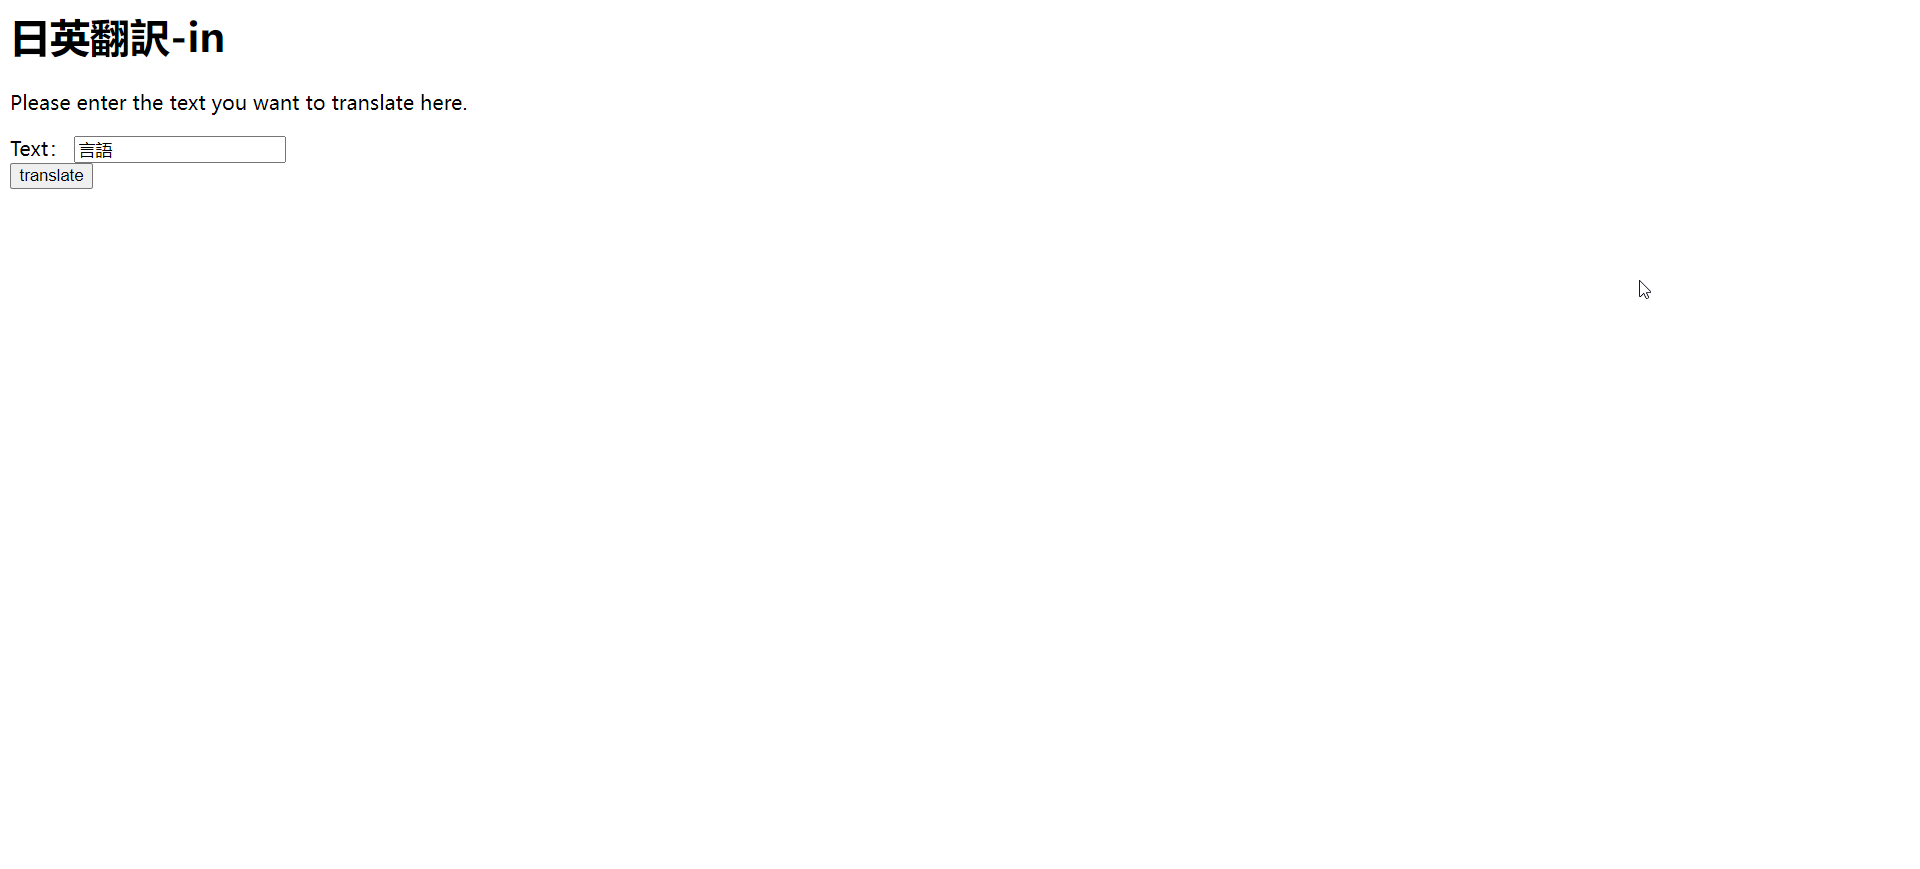

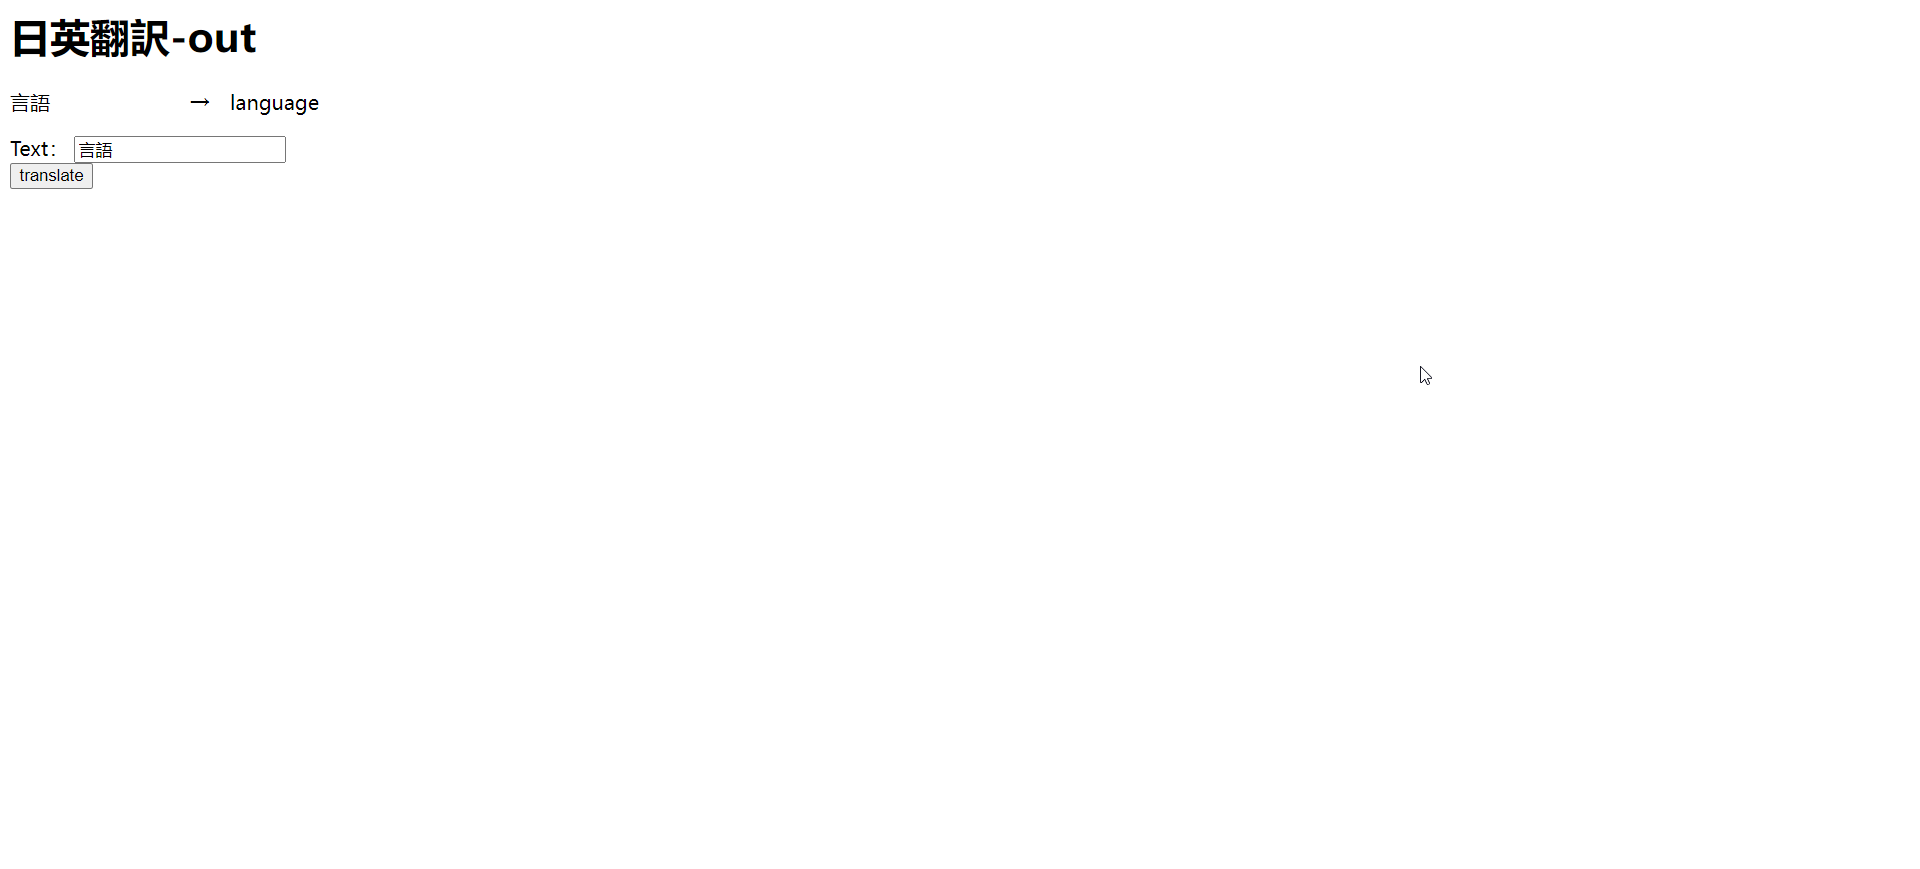